### Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока  

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

В контексте нашей задачи - это одно и то же.  
Начнем с векторного представления и сегментов новостей.

### Задача тематического моделирования

[Вероятностное тематическое моделирование LDA/ARTM Воронцов К.В. (МФТИ)](http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf)

In [6]:
# установим razdel - библиотека для токенизации
# !pip install razdel

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [3]:
# установим razdel - библиотека для обработки, нормалицации слов
# stemming - обрезает слова для чего-то простого типа чат-бота
# https://habr.com/ru/company/Voximplant/blog/446738/

# !pip install pymorphy2

     |████████████████████████████████| 55 kB 1.9 MB/s eta 0:00:011
     |████████████████████████████████| 8.2 MB 7.2 MB/s eta 0:00:01     |████████████████████▉           | 5.3 MB 4.2 MB/s eta 0:00:01
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=ed90ca07060d266033d40d7ac60649e0c3ac26e178f7dae949f99b36da2cc8ca
  Stored in directory: /Users/Katrinka/Library/Caches/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt
You should consider upgrading via the '/usr/local/opt/python@3.8/bin/python3.8 -m pip install --upgrade pip' command.


In [16]:
# !pip install gensim nltk

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
     |████████████████████████████████| 1.5 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 7.2 MB/s eta 0:00:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is depr

У нас есть три датасета:

1) Новости: id и текст самой новости;  
2) Список новостей, которые прочел пользователь: uid и список id статей, которые он прочел;  
3) Информация об оттоке: uid, churn;

In [127]:
import pandas as pd

In [128]:
# Загрузим датасет новостей
news = pd.read_csv("lection2_materials/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [129]:
# Загрузим пользователей и списки последних прочитанных новостей
users = pd.read_csv("lection2_materials/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [130]:
# Загрузим данные по оттоку клиентов - таргет
target = pd.read_csv("lection2_materials/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


Нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей  

[Gensim - руководство для начинающих](https://webdevblog.ru/gensim-rukovodstvo-dlya-nachinajushhih/)

In [131]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [132]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize
# https://github.com/natasha/razdel

import pymorphy2 

In [133]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Katrinka/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [134]:
# загружаем стоп-слова Русского языка 
stopword_ru = stopwords.words('russian')

# создаем морфологический анализатор (экземпляр класса)
morph = pymorphy2.MorphAnalyzer()

In [135]:
len(stopword_ru)

151

In [136]:
# добавим к стоп-словам еще один список из нашего дополнительного файла

with open('lection2_materials/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords

len(stopword_ru)

776

In [137]:
stopword_ru[55]

'опять'

In [138]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub("n", ' ', text)

    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    #print(tokens)
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
                #print(temp_cach)
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form # приводим слово к нормальной форме
                words_lem.append(temp_cach)
                #print(w,' : ',temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    #print(words_lem_without_stopwords)
    return words_lem_without_stopwords

In [140]:
list(tokenize(news.iloc[0,1][:100],   ))

[Substring(0, 11, 'Заместитель'),
 Substring(12, 24, 'председателя'),
 Substring(24, 25, 'n'),
 Substring(25, 38, 'правительства'),
 Substring(39, 41, 'РФ'),
 Substring(41, 42, 'n'),
 Substring(42, 48, 'Сергей'),
 Substring(48, 49, 'n'),
 Substring(49, 55, 'Иванов'),
 Substring(55, 56, 'n'),
 Substring(56, 62, 'избран'),
 Substring(63, 76, 'председателем'),
 Substring(77, 83, 'совета'),
 Substring(83, 84, 'n'),
 Substring(84, 87, 'ПБК'),
 Substring(88, 92, 'ЦСКА'),
 Substring(92, 93, 'n'),
 Substring(93, 94, '.'),
 Substring(95, 98, 'Как'),
 Substring(99, 100, 'с')]

In [141]:
# очищаем каждую статью 
norm_text = news.iloc[:2,1].apply(lambda x: clean_text(x), 1)
norm_text

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [142]:
# вот так выглядит статья, которая прошла лемматизацию, по сути это список из слов-токенов, которые есть в статье
lemmatization(norm_text[0])

['заместитель',
 'председатель',
 'правительство',
 'рф',
 'сергей',
 'иванов',
 'избрать',
 'председатель',
 'совет',
 'пбк',
 'цска',
 'прессслужба',
 'армеец',
 'решение',
 'единогласно',
 'принять',
 'первый',
 'заседание',
 'совет',
 'клуб',
 'основной',
 'функция',
 'орган',
 'обсуждение',
 'текущий',
 'состояние',
 'планирование',
 'утверждение',
 'стратегия',
 'развитие',
 'клуб',
 'близкий',
 'перспектива',
 'состав',
 'совет',
 'войти',
 'георгий',
 'полтавченко',
 'полномочный',
 'центральный',
 'федеральный',
 'округ',
 'алексей',
 'седов',
 'генералполковник',
 'начальник',
 'служба',
 'защита',
 'конституционный',
 'строй',
 'борьба',
 'терроризм',
 'фсб',
 'рф',
 'александр',
 'новак',
 'заместитель',
 'министр',
 'финансы',
 'рф',
 'вячеслав',
 'полтавец',
 'заместитель',
 'генеральный',
 'директор',
 'руководитель',
 'блок',
 'взаимодействие',
 'орган',
 'власть',
 'социальный',
 'корпоративный',
 'политика',
 'гмк',
 'норильский',
 'никель',
 'леонид',
 'исакович',
 '

In [143]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

CPU times: user 44.6 s, sys: 737 ms, total: 45.3 s
Wall time: 46.6 s


In [144]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 7min 18s, sys: 6.04 s, total: 7min 24s
Wall time: 9min 15s


А теперь в 3 строчки обучим нашу модель

In [145]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
# создаем словарь из всех встречающихся в датасете слов 
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [146]:
common_dictionary[5]

'баскетбол'

In [147]:
common_dictionary.id2token

{0: 'александр',
 1: 'алексей',
 2: 'андрей',
 3: 'армеец',
 4: 'банк',
 5: 'баскетбол',
 6: 'близкий',
 7: 'блок',
 8: 'борьба',
 9: 'ватутин',
 10: 'взаимодействие',
 11: 'власть',
 12: 'войти',
 13: 'вячеслав',
 14: 'генералполковник',
 15: 'генеральный',
 16: 'георгий',
 17: 'гмк',
 18: 'директор',
 19: 'европа',
 20: 'единогласно',
 21: 'заместитель',
 22: 'заседание',
 23: 'защита',
 24: 'иванов',
 25: 'избрать',
 26: 'исакович',
 27: 'клиентский',
 28: 'клуб',
 29: 'конституционный',
 30: 'корпоративный',
 31: 'леонид',
 32: 'лопат',
 33: 'министр',
 34: 'мир',
 35: 'начальник',
 36: 'никель',
 37: 'новак',
 38: 'норильский',
 39: 'оао',
 40: 'обсуждение',
 41: 'округ',
 42: 'ольга',
 43: 'ооо',
 44: 'орган',
 45: 'основной',
 46: 'пбк',
 47: 'первый',
 48: 'перспектива',
 49: 'планирование',
 50: 'плешаков',
 51: 'политика',
 52: 'полномочный',
 53: 'полтавец',
 54: 'полтавченко',
 55: 'правительство',
 56: 'правление',
 57: 'председатель',
 58: 'прессслужба',
 59: 'принять',
 

Делаем BoW по списку слов

In [148]:
common_dictionary.doc2bow(['баскетбол' ,'баскетбол' ,'наше', 'все'], allow_update=True)

[(5, 2), (135645, 1), (135646, 1)]

In [149]:
common_corpus[0][0]

(0, 2)

In [150]:
len(texts[0])

113

Все просто - это словарь наших слов

Запускаем обучение

In [243]:
N_topic = 20 # число тем - гиперпараметр

In [244]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
# модель, которая делает разбивку по темам 
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 34s, sys: 5.17 s, total: 1min 39s
Wall time: 1min 17s


In [245]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [246]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(3, 0.0978226),
 (4, 0.1006992),
 (5, 0.10956542),
 (8, 0.0318433),
 (10, 0.6133451),
 (17, 0.027657432)]

In [247]:
x=lda.show_topics(num_topics=N_topic, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: россия российский млрд исследование земля система глава вопрос ракета правительство путин экономика журнал цена всё
topic_1: сектор кожа перевод резерв египетский работодатель зампред предмет fo святой методика законодательство этаж парижский училище
topic_2: рейтинг особенность ученик место балл поражать моделирование строчка школьный третий занять forbes иркутск расположиться преобладать
topic_3: украина россия снижение банк киев украинский ребёнок решение восток санкция спрос египет всё первый обвинение
topic_4: автор научный большой возраст проверка всё продукция топливо последний очень специалист земля кровь мир первый
topic_5: обращение налог звезда треть сенатор остаток брюссель надёжный горизонт сестра звёздный римский химия репутация оперативно
topic_6: фонд украина всё ребёнок наука университет эксперт новый россия украинский объём увеличение исследование жизнь иметь
topic_7: рубль статья рост тыс население писать научный млн доллар эксперт вырасти месяц размер иссле

Очень неплохо - большинство тем вполне можно описать о чем они


построим темы 

In [248]:
news['title'].iloc[5]

['ио',
 'главное',
 'тренер',
 'вячеслав',
 'буцай',
 'прокомментировать',
 'победа',
 'югра',
 'матч',
 'регулярный',
 'чемпионат',
 'кхл',
 'прежде',
 'хотеть',
 'поблагодарить',
 'ребята',
 'команда',
 'передавать',
 'официальный',
 'сайт',
 'югра',
 'игра',
 'начинаться',
 'очень',
 'удачно',
 'пропустить',
 'гол',
 'первый',
 'смена',
 'долго',
 'входить',
 'игра',
 'связать',
 'дневный',
 'матч',
 'непривычный',
 'плюс',
 'третий',
 'матч',
 'сибирь',
 'гдеть',
 'ребята',
 'чувствовать',
 'скажем',
 'сонный',
 'второй',
 'третий',
 'период',
 'показать',
 'разбежаться',
 'играть',
 'правильно',
 'появиться',
 'момент',
 'дотерпеть',
 'заслуженно',
 'победить']

In [249]:
lda[common_dictionary.doc2bow(news['title'].iloc[10])]

[(10, 0.4500587), (14, 0.51872826)]

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [250]:
#text = news['title'].iloc[0]

# переразмечаем тамы, то есть каждому индексу статьи будет соответствовать индекс lda тем (вероятности)
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [251]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(N_topic)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.077242,0.0,0.0,0.023051,0.0,0.0,0.0,0.000000,0.000000,0.0
1,4896,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.974993,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,4897,0.0,0.0,0.0,0.097351,0.100965,0.109563,0.0,0.0,0.031844,...,0.613552,0.0,0.0,0.000000,0.0,0.0,0.0,0.027658,0.000000,0.0
3,4898,0.0,0.0,0.0,0.069390,0.105739,0.000000,0.0,0.0,0.000000,...,0.391922,0.0,0.0,0.422527,0.0,0.0,0.0,0.000000,0.000000,0.0
4,4899,0.0,0.0,0.0,0.000000,0.000000,0.210794,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.504368,0.0


In [252]:
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.077242,0.0,0.0,0.023051,0.0,0.0,0.0,0.000000,0.000000,0.0
1,4896,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.974993,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
2,4897,0.0,0.0,0.0,0.097351,0.100965,0.109563,0.0,0.0,0.031844,...,0.613552,0.0,0.0,0.000000,0.0,0.0,0.0,0.027658,0.000000,0.0
3,4898,0.0,0.0,0.0,0.069390,0.105739,0.000000,0.0,0.0,0.000000,...,0.391922,0.0,0.0,0.422527,0.0,0.0,0.0,0.000000,0.000000,0.0
4,4899,0.0,0.0,0.0,0.000000,0.000000,0.210794,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.504368,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [253]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


In [254]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(N_topic)]].values))

In [255]:
doc_dict[323426]

array([0.066816  , 0.        , 0.        , 0.        , 0.09496625,
       0.        , 0.02338729, 0.08098955, 0.        , 0.16907668,
       0.        , 0.        , 0.        , 0.06537013, 0.24703202,
       0.12185331, 0.        , 0.        , 0.1259236 , 0.        ])

In [256]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #print(user_vector)
    user_vector1 = np.mean(user_vector, 0)  # можно не средний
    return user_vector1 #,user_vector

In [257]:
user_articles_list = users['articles'].iloc[33]

In [258]:
vv = get_user_embedding(user_articles_list)
vv

array([0.26309054, 0.        , 0.        , 0.13908483, 0.04509653,
       0.        , 0.04681538, 0.04903178, 0.        , 0.178724  ,
       0.        , 0.        , 0.01007914, 0.02868581, 0.1203914 ,
       0.05067247, 0.        , 0.03533753, 0.01949123, 0.        ])

In [259]:
import matplotlib.pyplot as plt

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [260]:
#users['articles'].iloc[33]

In [261]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [262]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.133009,0.0,0.000000,0.185612,0.040072,0.023022,0.045572,0.097732,0.0,...,0.018639,0.023651,0.004768,0.061062,0.087682,0.089741,0.000000,0.022292,0.076532,0.002003
1,u108690,0.181821,0.0,0.000000,0.155994,0.040729,0.010472,0.114500,0.066138,0.0,...,0.006735,0.006444,0.002712,0.064217,0.115634,0.055097,0.013321,0.004537,0.000000,0.005975
2,u108339,0.216758,0.0,0.002294,0.087835,0.015349,0.011463,0.022881,0.029549,0.0,...,0.012168,0.003342,0.005016,0.050166,0.279318,0.055698,0.002610,0.027274,0.032633,0.006326


Датасет готов - можно попробовать обучить модель. Объединим датасет

In [263]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.133009,0.0,0.000000,0.185612,0.040072,0.023022,0.045572,0.097732,0.0,...,0.023651,0.004768,0.061062,0.087682,0.089741,0.000000,0.022292,0.076532,0.002003,0
1,u108690,0.181821,0.0,0.000000,0.155994,0.040729,0.010472,0.114500,0.066138,0.0,...,0.006444,0.002712,0.064217,0.115634,0.055097,0.013321,0.004537,0.000000,0.005975,1
2,u108339,0.216758,0.0,0.002294,0.087835,0.015349,0.011463,0.022881,0.029549,0.0,...,0.003342,0.005016,0.050166,0.279318,0.055698,0.002610,0.027274,0.032633,0.006326,1


In [264]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [265]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=0, test_size=0.25)

In [266]:
logreg = LogisticRegression(C=1.0)
#обучим наш пайплайн
logreg.fit(X_train, y_train)

LogisticRegression()

In [267]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.10077425, 0.04731765, 0.54676677, 0.42834566, 0.03728237,
       0.04000905, 0.17454755, 0.00954489, 0.21360404, 0.13343793])

In [268]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

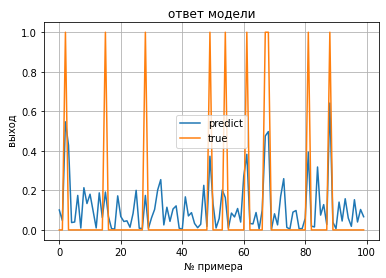

In [269]:
plt.plot( preds[:100], label = 'predict')
plt.plot(y_test.values[:100], label = 'true')
plt.title('ответ модели')
plt.xlabel(' № примера')
plt.ylabel(' выход')
plt.legend()
plt.grid('On')
plt.show()

In [270]:
precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.272032, F-Score=0.586, Precision=0.560, Recall=0.615


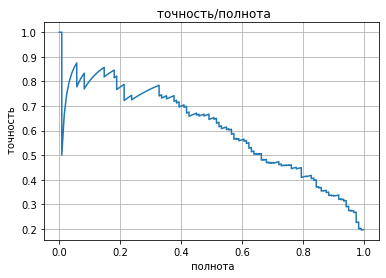

In [271]:
plt.plot(recall,precision )
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

In [272]:
import itertools

In [273]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1643  112]
 [ 100  145]]


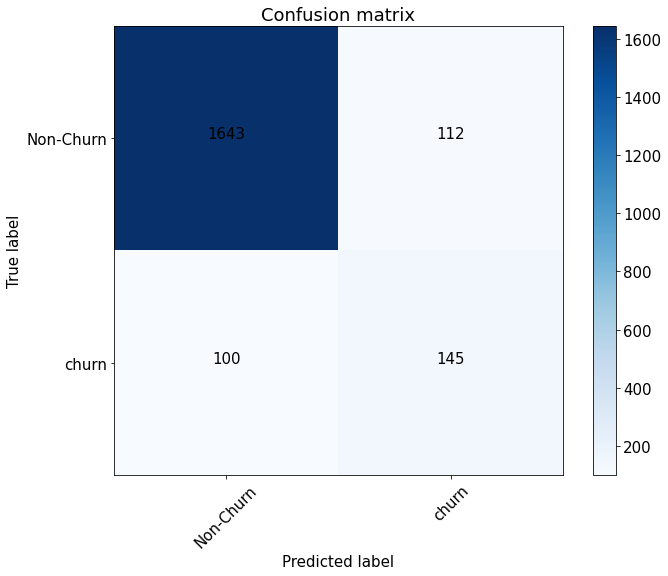

In [274]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [275]:
roc_auc_score(y_test, preds)

0.9166928309785453

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

__1.__ Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)  

__2.__ Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [276]:
def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.median(user_vector, 0)  
    return user_vector1

In [277]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.093617,0.0,0.0,0.063395,0.000000,0.020420,0.000000,0.028501,0.0,...,0.0,0.0,0.034233,0.044280,0.040847,0.0,0.000000,0.029166,0.0,0
1,u108690,0.179356,0.0,0.0,0.111042,0.022073,0.007135,0.107505,0.041293,0.0,...,0.0,0.0,0.027936,0.082723,0.044332,0.0,0.000000,0.000000,0.0,1
2,u108339,0.244159,0.0,0.0,0.099322,0.010721,0.000000,0.019705,0.028529,0.0,...,0.0,0.0,0.035925,0.329487,0.067760,0.0,0.006104,0.007563,0.0,1


In [278]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=5, test_size=0.25)

logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [279]:
precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore = (2 * precision * recall) / (precision + recall)

# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.247614, F-Score=0.664, Precision=0.605, Recall=0.736


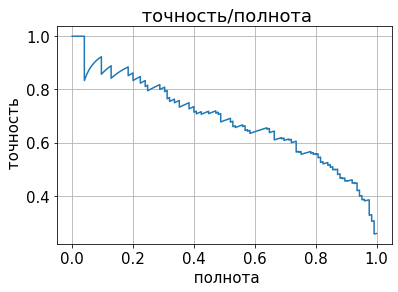

In [280]:
plt.plot(recall,precision )
plt.title(' точность/полнота')
plt.xlabel(' полнота')
plt.ylabel(' точность')
plt.grid('On')
plt.show()

Confusion matrix, without normalization
[[1632  126]
 [  60  182]]


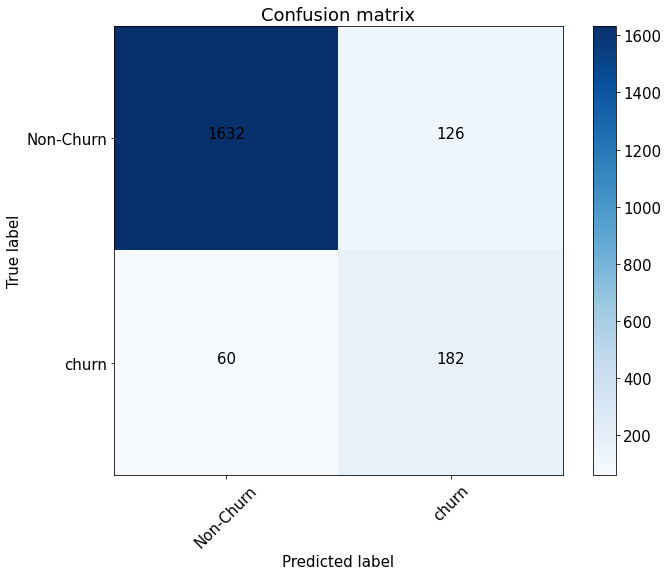

In [281]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [282]:
roc_auc_score(y_test, preds)

0.9476819075019509

__3.__ Повторить п.2, но используя уже не медиану, а max

In [283]:
def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector1 = np.max(user_vector, 0)  
    return user_vector1

In [284]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(N_topic)]]

X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.368888,0.0,0.000000,0.778653,0.182160,0.052510,0.230630,0.400109,0.0,...,0.141905,0.028606,0.150815,0.262684,0.235484,0.000000,0.100349,0.332104,0.012018,0
1,u108690,0.344167,0.0,0.000000,0.307285,0.115609,0.031864,0.216392,0.170576,0.0,...,0.038663,0.016269,0.254978,0.391579,0.182691,0.079927,0.015535,0.000000,0.035850,1
2,u108339,0.294718,0.0,0.013766,0.158944,0.048515,0.049319,0.049990,0.063955,0.0,...,0.020051,0.030094,0.168470,0.440910,0.085858,0.015662,0.131793,0.105324,0.023288,1


In [285]:
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(N_topic)]], 
                                                    X['churn'], random_state=5, test_size=0.25)

logreg = LogisticRegression(C=1.0)
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [286]:
precision, recall, thresholds = precision_recall_curve(y_test.values[:1000], preds[:1000])

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.346059, F-Score=0.744, Precision=0.769, Recall=0.720


Confusion matrix, without normalization
[[1702   56]
 [  68  174]]


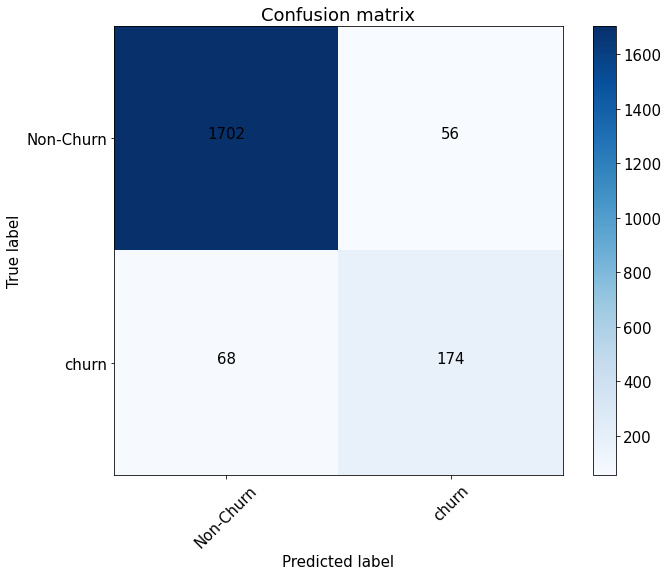

In [287]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [288]:
roc_auc_score(y_test, preds)

0.9625701633148112

__4.__ (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.  

__5.__ Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score  

**N_topic = 10**  
model_1 (np.mean): F-Score=0.613, Precision=0.670, Recall=0.566, ROC AUC score: 0.907  
model_2 (np.median): F-Score=0.605, Precision=0.568, Recall=0.648, ROC AUC score: 0.893  
model_3 (np.max): F-Score=0.647, Precision=0.592, Recall=0.713, ROC AUC score: 0.922  

**N_topic = 15**
model_1 (np.mean): F-Score=0.523, Precision=0.405, Recall=0.738, ROC AUC score: 0.882 
model_2 (np.median): F-Score=0.603, Precision=0.624, Recall=0.584, ROC AUC score: 0.910
model_3 (np.max): F-Score=0.721, Precision=0.778, Recall=0.672, ROC AUC score: 0.947

**N_topic = 20**
model_1 (np.mean): F-Score=0.586, Precision=0.560, Recall=0.615, ROC AUC score: 0.948 
model_2 (np.median): F-Score=0.664, Precision=0.605, Recall=0.736, ROC AUC score: 0.910
model_3 (np.max): F-Score=0.744, Precision=0.769, Recall=0.720, ROC AUC score: 0.963

__6.__ Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.

Самые лучшие значения метрик оказались при разбиении на 20 тем и при взятии максимального значения вероятности темы. Если мы будем брать среднее значение - мы можем сильно снизить вероятность чтения темы, но может оказаться, что пользователь читает эту тему. С медианой ситуация обстоит хуже так, как среди нескольких статей только одна может соответствовать теманике, а мы возьмем серединку, то есть искусственно снизим вероятность, при чем, скорее всего, еще сильнее, чем при взятии среднего значения, по-этому лучшим способом создания вектора пользователя взять максимально возможную вероятность прочтения тем 